In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")

### Load Data

In [7]:
folder_FUS_FL = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT"
os.chdir(folder_FUS_FL)
dict_d2center = pickle.load(open("distance2center-DataDict-pooled-perTrack.p", "rb"))
dict_d2center.keys()

dict_keys(['filenames_FUS', 'filenames_RNA', 'lst_N_locations_FUS', 'lst_N_locations_RNA', 'lst_df_FUS_d2center', 'lst_df_RNA_d2center'])

### Functions

In [84]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std

def critical_system_PCF(r, A, characteristic_size):
     Gr = 1 + A * np.exp(- r / characteristic_size)
     return Gr

### Domain distribution in condensate

In [39]:
lst_df_FUS_d2center = dict_d2center["lst_df_FUS_d2center"]
lst_df_RNA_d2center = dict_d2center["lst_df_RNA_d2center"]
lst_d2center_norm_FUS = [
    df["d2center_norm"].to_numpy(float) for df in lst_df_FUS_d2center
]
d2center_norm_FUS = np.hstack(lst_d2center_norm_FUS)
lst_d2center_norm_RNA = [
    df["d2center_norm"].to_numpy(float) for df in lst_df_RNA_d2center
]
d2center_norm_RNA = np.hstack(lst_d2center_norm_RNA)

r_max = 1
ringwidth = 0.2
dr_slidingrings = 0.05
bin_starts = np.arange(0, r_max - ringwidth, dr_slidingrings)
bin_ends = bin_starts + ringwidth
ring_areas = np.pi * (bin_ends**2 - bin_starts**2)


def calculate_hist(d2center_norm, r_max, bin_starts, bin_ends, ring_areas):
    # calculate histogram
    lst_hist = []
    for distance in d2center_norm[d2center_norm <= r_max]:
        lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
    hist = np.sum(lst_hist, axis=0)

    # determine normalization factors
    N_domains = d2center_norm[d2center_norm <= r_max].shape[0]
    rho_per_unit_circle = N_domains / (np.pi * 1**2)
    norm_factors = ring_areas * rho_per_unit_circle
    distribution = hist / norm_factors
    probability_norm = distribution / distribution.sum()

    return probability_norm


def bootstrap(d2center_norm, bs_size, bs_rounds):
    lst_probability_norm = []
    for i in track(range(bs_rounds)):
        idxs = np.random.choice(len(d2center_norm), bs_size)
        d2center_norm_bs = np.array([d2center_norm[idx] for idx in idxs], float)
        probability_norm = calculate_hist(
            d2center_norm_bs, r_max, bin_starts, bin_ends, ring_areas
        )

        lst_probability_norm.append(probability_norm)

    probability_norm_array = np.stack(lst_probability_norm)

    return probability_norm_array


probability_norm_FUS_array = bootstrap(d2center_norm_FUS, bs_size=10000, bs_rounds=5000)
probability_norm_RNA_array = bootstrap(d2center_norm_RNA, bs_size=10000, bs_rounds=5000)

Output()

Output()

In [46]:
lst_FUS_mean = []
lst_FUS_err = []
for i in range(probability_norm_FUS_array.shape[1]):
    column = probability_norm_FUS_array[:, i]
    ci = (np.percentile(column, 5), np.percentile(column, 95))
    bs_mean = np.mean(ci)
    bs_err = (ci[1] - ci[0]) / 2
    lst_FUS_mean.append(bs_mean)
    lst_FUS_err.append(bs_err)


lst_RNA_mean = []
lst_RNA_err = []
for i in range(probability_norm_RNA_array.shape[1]):
    column = probability_norm_RNA_array[:, i]
    ci = (np.percentile(column, 5), np.percentile(column, 95))
    bs_mean = np.mean(ci)
    bs_err = (ci[1] - ci[0]) / 2
    lst_RNA_mean.append(bs_mean)
    lst_RNA_err.append(bs_err)

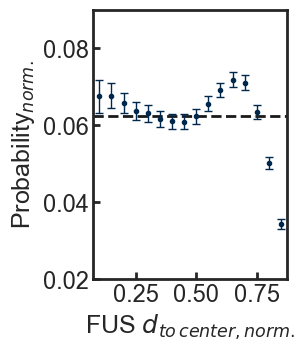

In [86]:
fontsize = 18
plt.figure(figsize=(2.5, 3.5))
plt.axhline(1 / len(bin_starts), c="k", ls="--", lw=2)
bar_x = (bin_starts + bin_ends) / 2
plt.errorbar(
    bar_x,
    lst_FUS_mean,
    yerr=lst_FUS_err,
    fmt=".",
    color="#00274c",
    ecolor="#00274c",
    elinewidth=1,
    capsize=3,
)
plt.xlim(bar_x[0] - dr_slidingrings / 2, bar_x[-1] + dr_slidingrings / 2)
# plt.xlim(0, 1)
plt.ylim(0.02, 0.09)
plt.xlabel(r"FUS $\mathit{d}$$_{to\/center,norm.}$", fontsize=fontsize)
plt.ylabel("Probability$_{norm.}$", fontsize=fontsize)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "FUS_d2center_distribution.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

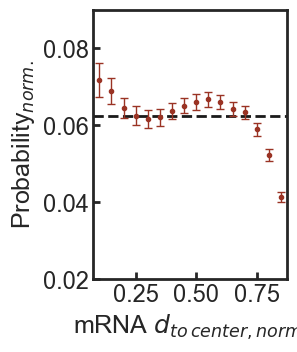

In [85]:
fontsize = 18
plt.figure(figsize=(2.5, 3.5))
plt.axhline(1 / len(bin_starts), c="k", ls="--", lw=2)
bar_x = (bin_starts + bin_ends) / 2
plt.errorbar(
    bar_x,
    lst_RNA_mean,
    yerr=lst_RNA_err,
    fmt=".",
    color="#9a3324",
    ecolor="#9a3324",
    elinewidth=1,
    capsize=3,
)
plt.xlim(bar_x[0] - dr_slidingrings / 2, bar_x[-1] + dr_slidingrings / 2)
plt.ylim(0.02, 0.09)
plt.xlabel(r"mRNA $\mathit{d}$$_{to\/center,norm.}$", fontsize=fontsize)
plt.ylabel("Probability$_{norm.}$", fontsize=fontsize)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "RNA_d2center_distribution.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)